In [1]:
from generate_data import Generator
import pandas as pd

generator = Generator(
    p_ag_lh=0.95,
    p_ag_mt=0.6,
    p_ag_tv=0.3,
    p_ct_lh=0.5,
    p_ct_mt=0.3,
    p_ct_tv=0.2,
    ag_mu=0.6,
    ag_sm=0.25,
    max_cap=100,
    num_agents=80,
    num_customers=10000
)
generator.generate_agents()
generator.generate_customers()

In [2]:
agents = pd.read_csv("../data/agents.csv")
customers = pd.read_csv("../data/customers.csv")

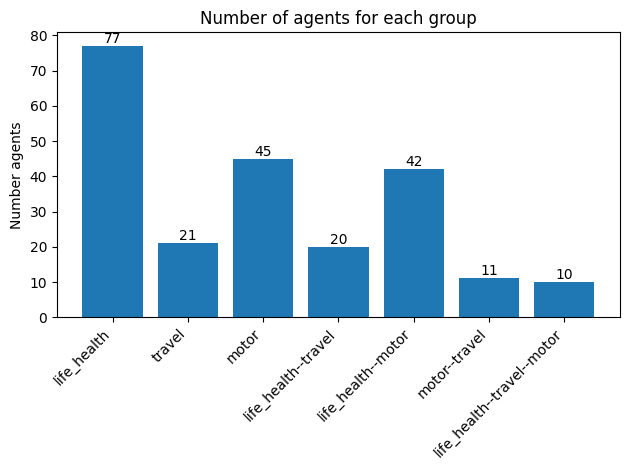

In [3]:
from utils import agents_categories_stats

agents_categories_stats(agents=agents,
                        cols=[
                            "life_health",
                            "travel",
                            "motor",
                            ["life_health", "travel"],
                            ["life_health", "motor"],
                            ["motor", "travel"],
                            ["life_health", "travel", "motor"]
                        ])

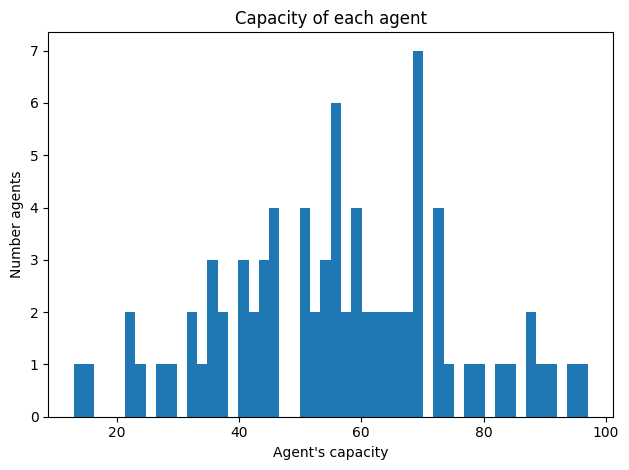

In [4]:
from utils import agents_capacity_stats

agents_capacity_stats(agents=agents)

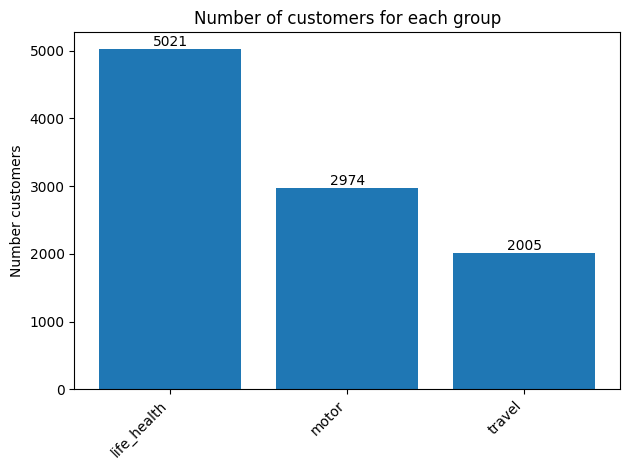

In [5]:
from utils import customers_categories_stats
customers_categories_stats(customers=customers)

In [6]:
from pyspark.sql import SparkSession
import warnings
warnings.filterwarnings("ignore")

spark = SparkSession.builder.appName("Assign customer for agents")\
                            .master("local[4]")\
                            .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")
spark

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/31 12:07:25 WARN Utils: Your hostname, DELL, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/12/31 12:07:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/31 12:07:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BooleanType
agent_schema = StructType([
    StructField("id", IntegerType()),
    StructField("life_health", BooleanType()),
    StructField("motor", BooleanType()),
    StructField("travel", BooleanType()),
    StructField("capacity", IntegerType())
])

customer_schema = StructType([
    StructField("id", IntegerType()),
    StructField("demand", StringType())
])

In [8]:
agents_df = spark.read.csv("../data/agents.csv", header=True, schema=agent_schema)
customers_df = spark.read.csv("../data/customers.csv", header=True, schema=customer_schema)

In [9]:
agents_df.show(10)
agents_df.printSchema()

+---+-----------+-----+------+--------+
| id|life_health|motor|travel|capacity|
+---+-----------+-----+------+--------+
|  0|       true| true| false|      46|
|  1|      false| true| false|      58|
|  2|       true| true| false|      65|
|  3|       true|false|  true|      72|
|  4|       true| true| false|      55|
|  5|       true| true| false|      40|
|  6|       true|false|  true|      65|
|  7|       true|false|  true|      80|
|  8|       true| true| false|      46|
|  9|       true| true| false|      55|
+---+-----------+-----+------+--------+
only showing top 10 rows
root
 |-- id: integer (nullable = true)
 |-- life_health: boolean (nullable = true)
 |-- motor: boolean (nullable = true)
 |-- travel: boolean (nullable = true)
 |-- capacity: integer (nullable = true)



In [10]:
customers_df.show(10)
customers_df.printSchema()

+---+-----------+
| id|     demand|
+---+-----------+
|  0|life_health|
|  1|      motor|
|  2|      motor|
|  3|      motor|
|  4|life_health|
|  5|life_health|
|  6|life_health|
|  7|     travel|
|  8|life_health|
|  9|life_health|
+---+-----------+
only showing top 10 rows
root
 |-- id: integer (nullable = true)
 |-- demand: string (nullable = true)



In [11]:
from pyspark.sql.functions import col, sum

In [12]:
demands_order_by_total_slots = customers_df.select(col("demand")).groupby("demand").count().alias("count").orderBy(col("count").asc())
demands_order_by_total_slots.show()
categories = [(row["demand"], row["count"]) for row in demands_order_by_total_slots.collect()]
categories

+-----------+-----+
|     demand|count|
+-----------+-----+
|     travel| 2005|
|      motor| 2974|
|life_health| 5021|
+-----------+-----+



[('travel', 2005), ('motor', 2974), ('life_health', 5021)]

In [13]:
agents_df = agents_df.withColumn("remain", col("capacity"))

In [14]:
from pyspark.sql.window import Window
from pyspark.sql.functions import floor, sum, lit, sequence, explode, row_number

for category, demand in categories:
    # Lấy ra id và remain tương ứng với mỗi agent
    agents = agents_df.select(col("id"), col("remain")).filter((col(category) == True) & (col("remain") > 0))

    # Lấy ra customers cần gán agents tư vấn bao gồm id
    customers = customers_df.select(col("id")).filter(col("demand") == category)
        
    # Tính toán trước giá trị tổng số khả năng tiếp nhận khách hàng ứng với loại bảo hiểm
    total_cap = agents.select(sum(col("remain")).alias("total")).collect()
    agent_cap = total_cap[0]["total"]

    if agent_cap <= demand:
        ##################
        # Phần này xử lý với trường hợp mà tổng số khả năng đáp ứng nhỏ hơn hoặc bằng với tổng số yêu cầu
        ##################

        # Gán số lượng khách hàng cho mỗi agents với khả năng tối đa
        agents = agents.withColumn("assigned", col("remain"))
        
        # Cập nhật bảng agents_df sau khi xử lý gán khách hàng cho agents
        agents_df = agents_df.join(agents, agents_df.id == agents.id, how="left").select(agents_df["*"], agents["assigned"])
        agents_df = agents_df.fillna({"assigned": 0})
        agents_df = agents_df.withColumn("remain", col("remain") - col("assigned"))
        agents_df = agents_df.drop("assigned")
    else:
        
        ##################
        # Phần này xử lý với trường hợp mà tổng số khả năng đáp ứng lớn hơn so với tổng số yêu cầu
        ##################
        
        # Thêm các cột về số lượng khách hàng được gán "assigned" và cột phần dư thập phân sau khi tính toán 
        agents = agents.withColumn("assigned", floor((col("remain")*demand)/agent_cap))\
                       .withColumn("decimal_part", (col("remain")*demand)/agent_cap - floor((col("remain")*demand)/agent_cap))

        # Tính toán số lượng yêu cầu của khách hàng khi chưa được đáp ứng sau khi chia ở bên trên
        remain_demand = demand - agents.select(sum(col("assigned")).alias("total")).collect()[0]["total"]
        tmp_agents = (
            agents
                .orderBy(col("decimal_part").desc(), col("id"))
                .limit(remain_demand)
                .select(col("id"))
        )

        # Với mỗi agent sẽ gán cho 1 khách hàng
        tmp_agents = tmp_agents.withColumn("added", lit(1))
        agents = agents.join(tmp_agents, agents.id == tmp_agents.id, how="left").select(agents["*"], tmp_agents["added"])
        
        # Thay thế giá trị null của cột added sau khi join
        agents = agents.fillna({"added": 0})

        # Cập nhật cột assigned
        agents = agents.withColumn("assigned", col("assigned") + col("added"))
        agents = agents.select(col("id"), col("assigned"))

        # Cập nhật bảng agents_df sau khi xử lý gán khách hàng cho agents
        agents_df = agents_df.join(agents, agents_df.id == agents.id, how="left").select(agents_df["*"], agents["assigned"])
        agents_df = agents_df.fillna({"assigned": 0})
        agents_df = agents_df.withColumn("remain", col("remain") - col("assigned"))
        agents_df = agents_df.drop("assigned")
    
    agents = agents.withColumn("rep", explode(sequence(lit(1), col("assigned"))))
    agents = agents.select(col("id"))
    w = Window.orderBy(col("id")) 
    agents = agents.withColumn("index", row_number().over(w) - 1)
    customers = customers.withColumn("index", row_number().over(w) - 1)
    customer_agent = customers.join(agents, "index", how="inner").select(customers["id"].alias("customer_id"), agents["id"].alias("agent_id"))
    customer_agent.toPandas().to_csv(f"../data/{category}.csv", index=False)

In [15]:
agents_df.orderBy(col("id").asc()).show(100)

+---+-----------+-----+------+--------+------+
| id|life_health|motor|travel|capacity|remain|
+---+-----------+-----+------+--------+------+
|  0|       true| true| false|      46|     0|
|  1|      false| true| false|      58|     0|
|  2|       true| true| false|      65|     0|
|  3|       true|false|  true|      72|     0|
|  4|       true| true| false|      55|     0|
|  5|       true| true| false|      40|     0|
|  6|       true|false|  true|      65|     0|
|  7|       true|false|  true|      80|     0|
|  8|       true| true| false|      46|     0|
|  9|       true| true| false|      55|     0|
| 10|       true| true| false|      66|     0|
| 11|       true|false| false|      67|     0|
| 12|       true|false| false|      63|     0|
| 13|       true|false| false|      84|     0|
| 14|       true|false|  true|      33|     0|
| 15|       true| true|  true|      82|     0|
| 16|       true| true|  true|      23|     0|
| 17|       true| true|  true|      70|     0|
| 18|       t